# Importing libraries

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.applications import nasnet
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from pathlib import Path

# Importing the dataset from kaggle

In [ ]:
! pip install kaggle

In [ ]:
!rm -rf /root/.kaggle

In [ ]:
!mkdir /root/.kaggle

In [ ]:
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 /content/drive/MyDrive/Kaggle/kaggle.json

In [ ]:
! kaggle datasets download crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:24<00:00, 115MB/s] 
100% 3.24G/3.24G [00:24<00:00, 142MB/s]


In [ ]:
!unzip /content/a-large-scale-fish-dataset.zip

# Creating the dataset itself

In [98]:
data_dir_train = pathlib.Path('/content/NA_Fish_Dataset')

In [101]:
image_dir = Path('/content/Fish_Dataset/Fish_Dataset')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [102]:
image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head(3)

,Filepath,Label
0,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream
1,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
2,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream


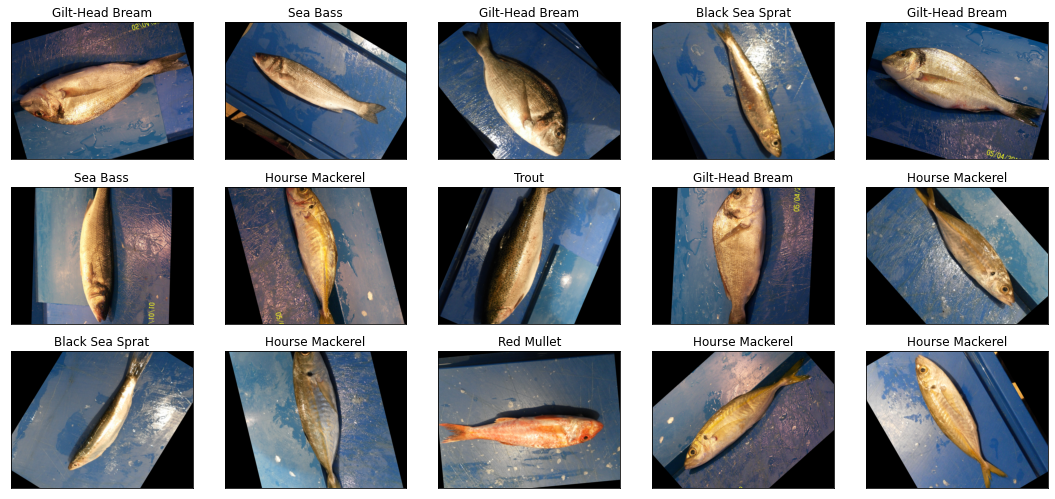

In [103]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

# Splitting the dataset

In [173]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [174]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    tf.keras.applications.inception_v3.preprocess_input
)


In [175]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [176]:
print(train_images)

# Creating the model

## Importing the pre-trained dataset

In [177]:
pre_trained_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150, 150,3),
    pooling='avg',
    classifier_activation="softmax",
)

for layer in pre_trained_model.layers:
  layer.trainable = False

## Creting the new layers

In [179]:
x = layers.Dense(128, activation= 'relu')(pre_trained_model.output)

x = layers.Dense(128, activation='relu')(x)

x = layers.Dense(9, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
model.summary()

## Fitting the model

In [181]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True
        )
    ]
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
90/90 [==============================] - 354s 4s/step - loss: 6.1722 - accuracy: 0.3184 - val_loss: 1.8532 - val_accuracy: 0.4396
Epoch 2/50
90/90 [==============================] - 344s 4s/step - loss: 1.5935 - accuracy: 0.4960 - val_loss: 1.5503 - val_accuracy: 0.5083
Epoch 3/50
90/90 [==============================] - 345s 4s/step - loss: 1.3362 - accuracy: 0.5632 - val_loss: 1.3416 - val_accuracy: 0.5597
Epoch 4/50
90/90 [==============================] - 340s 4s/step - loss: 1.1426 - accuracy: 0.6151 - val_loss: 1.2491 - val_accuracy: 0.5875
Epoch 5/50
90/90 [==============================] - 344s 4s/step - loss: 1.0889 - accuracy: 0.6342 - val_loss: 1.1289 - val_accuracy: 0.6285
Epoch 6/50
90/90 [==============================] - 340s 4s/step - loss: 0.9968 - accuracy: 0.6569 - val_loss: 1.0707 - val_accuracy: 0.6493
Epoch 7/50
90/90 [==============================] - 345s 4s/step - loss: 0.8691 - accuracy: 0.7071 - val_loss: 1.1092 - val_accuracy: 0.6431
Epoch 8/50
90

In [186]:
model.save('/content/drive/MyDrive/Colab Notebooks/Models/Fish_CNN_InceptionV3_2.h5')

# Model Evaluation

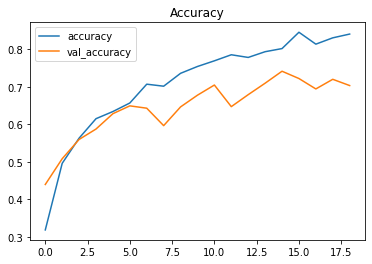

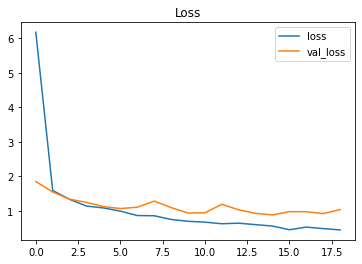

In [184]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()



pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")

plt.show()